# CS 7650 Final Project - Lexical Normalization

#### Import statements

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, BertTokenizer, DataCollatorForSeq2Seq, GPT2Tokenizer, BertModel, GPT2LMHeadModel, EncoderDecoderModel, GPT2Config
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import editdistance
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from google.colab import drive

drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Mounted at /content/drive
cuda


#### Process dataset

In [ ]:
class LexicalNormalizationDataset(Dataset):
    def __init__(self, x, y, tokenizer):
        self.encodings = tokenize_data(x, y, tokenizer)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

class TweetNormalizationDataset(Dataset):
    def __init__(self, sources, targets, tokenizer, max_input_len=64, max_target_len=64):
        self.inputs = tokenizer(sources, truncation=True, padding=True, max_length=max_input_len, return_tensors="pt")
        with tokenizer.as_target_tokenizer():
            self.targets = tokenizer(targets, truncation=True, padding=True, max_length=max_target_len, return_tensors="pt")
        self.inputs["labels"] = self.targets["input_ids"]

    def __len__(self):
        return len(self.inputs["input_ids"])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.inputs.items()}


def process_data(path):
    x, y = [], []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split("\t", 1)
            if len(parts) == 2:
                noisy = parts[0]
                clean = parts[1]
                x.append(noisy)
                y.append(clean)
    return x, y

def process_tweet_level_data(path):
    inputs, targets = [], []
    current_input, current_target = [], []
    with open(path, 'r') as f:
        for line in f:
            if line.strip() == "":
                if current_input:
                    inputs.append(" ".join(current_input))
                    targets.append(" ".join(current_target))
                    current_input, current_target = [], []
            else:
                parts = line.strip().split("\t", 1)
                if len(parts) == 2:
                    noisy = parts[0]
                    clean = parts[1]
                    current_input.append(noisy)
                    current_target.extend(clean.split())

    if current_input:
        inputs.append(" ".join(current_input))
        targets.append(" ".join(current_target))

    return inputs, targets

train_x, train_y = process_data("drive/MyDrive/Colab Notebooks/CS 7650/Final Project/data/train.norm")
test_x, test_y = process_data("drive/MyDrive/Colab Notebooks/CS 7650/Final Project/data/test.norm")
dev_x, dev_y = process_data("drive/MyDrive/Colab Notebooks/CS 7650/Final Project/data/dev.norm")

train_tweet_x, train_tweet_y = process_tweet_level_data("drive/MyDrive/Colab Notebooks/CS 7650/Final Project/data/train.norm")
dev_tweet_x, dev_tweet_y = process_tweet_level_data("drive/MyDrive/Colab Notebooks/CS 7650/Final Project/data/dev.norm")
test_tweet_x, test_tweet_y = process_tweet_level_data("drive/MyDrive/Colab Notebooks/CS 7650/Final Project/data/test.norm")


# Part 1: T5 Model

#### Tokenizer

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")

def tokenize_data(x, y, tokenizer, max_input_len=16, max_target_len=16):
    model_inputs = tokenizer(x, padding=True, truncation=True, max_length=max_input_len, return_tensors="pt")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(y, padding=True, truncation=True, max_length=max_target_len, return_tensors="pt")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = LexicalNormalizationDataset(train_x, train_y, tokenizer)
test_dataset = LexicalNormalizationDataset(test_x, test_y, tokenizer)
dev_dataset = LexicalNormalizationDataset(dev_x, dev_y, tokenizer)

train_tweet_dataset = TweetNormalizationDataset(train_tweet_x, train_tweet_y, tokenizer)
test_tweet_dataset = TweetNormalizationDataset(test_tweet_x, test_tweet_y, tokenizer)
dev_tweet_dataset = TweetNormalizationDataset(dev_tweet_x, dev_tweet_y, tokenizer)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


#### Train model

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

model_tweet = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="epoch",
    fp16=True,
    logging_dir="./logs",
    report_to="none",
)

training_tweet_args = TrainingArguments(
    output_dir="./tweet-results",
    eval_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    save_strategy="epoch",
    fp16=True,
    logging_dir="./tweet-logs",
    report_to="none",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer
)

trainer_tweet = Trainer(
    model=model,
    args=training_tweet_args,
    train_dataset=train_tweet_dataset,
    eval_dataset=dev_tweet_dataset,
    tokenizer=tokenizer
)

trainer.train()

trainer_tweet.train()

#### Evaluation and Inference

In [ ]:
def generate_predictions(model, tokenizer, inputs, batch_size=32, max_length=64):
    model.eval()
    preds = []
    for i in tqdm(range(0, len(inputs), batch_size)):
        batch_inputs = inputs[i:i+batch_size]
        encodings = tokenizer(batch_inputs, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model.generate(**encodings, max_length=max_length)
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        preds.extend([pred.strip() for pred in decoded])
    return preds

test_preds = generate_predictions(model, tokenizer, test_x)
test_tweet_preds = generate_predictions(model_tweet, tokenizer, test_tweet_x)

100%|██████████| 919/919 [04:00<00:00,  3.82it/s]


In [ ]:
# Save predictions

output_dir = 'drive/MyDrive/Colab Notebooks/CS 7650/Final Project'
test_preds_file = os.path.join(output_dir, 'test_preds.txt')
test_tweet_preds_file = os.path.join(output_dir, 'test_tweet_preds.txt')

with open(test_preds_file, 'w') as f:
    for pred in test_preds:
        f.write(pred + '\n')

with open(test_tweet_preds_file, 'w') as f:
    for pred in test_tweet_preds:
        f.write(pred + '\n')

print(f"Predictions saved to: {test_preds_file} and {test_tweet_preds_file}")

Predictions saved to: drive/MyDrive/Colab Notebooks/CS 7650/Final Project/test_preds.txt and drive/MyDrive/Colab Notebooks/CS 7650/Final Project/test_tweet_preds.txt


In [ ]:
# Read predictions

output_dir = 'drive/MyDrive/Colab Notebooks/CS 7650/Final Project'
test_preds_file = os.path.join(output_dir, 'test_preds.txt')
test_tweet_preds_file = os.path.join(output_dir, 'test_tweet_preds.txt')

with open(test_preds_file, 'r') as f:
    test_preds = [line.strip() for line in f]

with open(test_tweet_preds_file, 'r') as f:
    test_tweet_preds = [line.strip() for line in f]


In [ ]:
def compute_bleu(preds, refs):
    smoothie = SmoothingFunction().method4
    scores = [
        sentence_bleu([ref.split()], pred.split(), weights=(1, 0, 0, 0), smoothing_function=smoothie)
        for pred, ref in zip(preds, refs)
    ]
    return sum(scores) / len(scores)

def average_edit_distance(preds, refs):
    dists = [editdistance.eval(p, r) for p, r in zip(preds, refs)]
    return np.mean(dists)

def get_top_error_sources(inputs, preds, refs, top_n=10):
    errors = [inp for inp, pred, ref in zip(inputs, preds, refs) if pred.strip() != ref.strip()]
    counter = Counter(errors)
    return counter.most_common(top_n)

def get_words_not_normed(x, y):
    already_normed = sum(1 for src, tgt in zip(x, y) if src.strip() == tgt.strip())
    return (already_normed / len(x)) * 100 if len(x) > 0 else 0.0

def compute_err(accuracy, words_not_normed):
    return (accuracy * 100 - words_not_normed) / (100 - words_not_normed)

def compute_metrics(preds, inputs, labels):
    preds = [p.strip() for p in preds]
    labels = [l.strip() for l in labels]

    acc = accuracy_score(labels, preds)
    bleu = compute_bleu(preds, labels)
    edit_dist = average_edit_distance(preds, labels)
    top_error_sources = get_top_error_sources(inputs, preds, labels)
    err = compute_err(acc, get_words_not_normed(inputs, labels))

    return {
        "accuracy": acc,
        "bleu": bleu,
        "edit_distance": edit_dist,
        "top_error_sources": top_error_sources,
        "ERR": err
    }

metrics = compute_metrics(test_preds, test_x, test_y)
print("T5 Model Metrics:")
print("Accuracy: ", metrics["accuracy"])
print("BLEU: ", metrics["bleu"])
print("Average Edit Distance: ", metrics["edit_distance"])
print("ERR: ", metrics["ERR"])
print("Top 10 Error Sources:")
for source, count in metrics["top_error_sources"]:
    print(f"Word: {source}, Count: {count}")

metrics_tweet = compute_metrics(test_tweet_preds, test_tweet_x, test_tweet_y)
print("T5 Tweet Model Metrics:")
print("Accuracy: ", metrics_tweet["accuracy"])
print("BLEU: ", metrics_tweet["bleu"])
print("Average Edit Distance: ", metrics_tweet["edit_distance"])
print("ERR: ", metrics_tweet["ERR"])
print("Top 10 Error Sources:")
for source, count in metrics_tweet["top_error_sources"]:
    print(f"Word: {source}, Count: {count}")


# Part 2: BERT + GPT Model

#### Model Architecture

In [ ]:
def tokenize_tweet_pairs(sources, targets, max_input_len=5, max_target_len=None):
    encoder_inputs = bert_tokenizer(sources, padding="max_length", truncation=True, max_length=max_input_len, return_tensors="pt")

    decoder_inputs = gpt2_tokenizer(targets, padding="longest", truncation=True, max_length=max_target_len, return_tensors="pt") if max_target_len else gpt2_tokenizer(targets, padding="longest", return_tensors="pt")
    labels = decoder_inputs["input_ids"]
    labels[labels == gpt2_tokenizer.pad_token_id] = -100

    return {
        "input_ids": encoder_inputs["input_ids"],
        "attention_mask": encoder_inputs["attention_mask"],
        "decoder_input_ids": decoder_inputs["input_ids"],
        "labels": labels
    }


class TweetSeq2SeqDataset(Dataset):
    def __init__(self, sources, targets, max_input_len=5, max_target_len=None):
        self.data = tokenize_tweet_pairs(sources, targets, max_input_len=max_input_len, max_target_len=max_target_len)

    def __len__(self):
        return len(self.data["input_ids"])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.data.items()}

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
bert_gpt_model = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "gpt2")
bert_gpt_model.decoder.resize_token_embeddings(len(gpt2_tokenizer))

bert_gpt_model.config.decoder_start_token_id = gpt2_tokenizer.bos_token_id
bert_gpt_model.config.eos_token_id = gpt2_tokenizer.eos_token_id
bert_gpt_model.config.pad_token_id = gpt2_tokenizer.pad_token_id

bert_gpt_tweet_model = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "gpt2")
bert_gpt_tweet_model.decoder.resize_token_embeddings(len(gpt2_tokenizer))

bert_gpt_tweet_model.config.decoder_start_token_id = gpt2_tokenizer.bos_token_id
bert_gpt_tweet_model.config.eos_token_id = gpt2_tokenizer.eos_token_id
bert_gpt_tweet_model.config.pad_token_id = gpt2_tokenizer.pad_token_id


train_bert_dataset = TweetSeq2SeqDataset(train_x, train_y)
dev_bert_dataset = TweetSeq2SeqDataset(dev_x, dev_y)
train_bert_tweet_dataset = TweetSeq2SeqDataset(train_tweet_x, train_tweet_y, max_input_len=128, max_target_len=128)
dev_bert_tweet_dataset = TweetSeq2SeqDataset(dev_tweet_x, dev_tweet_y, max_input_len=128, max_target_len=128)

data_collator = DataCollatorForSeq2Seq(tokenizer=gpt2_tokenizer, model=bert_gpt_model, label_pad_token_id=-100)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros

In [ ]:
training_args = TrainingArguments(
    output_dir="./bert2gpt-results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=8,
    weight_decay=0.01,
    fp16=True,
    logging_dir="./bert2gpt-logs",
    report_to="none",
)

trainer = Trainer(
    model=bert_gpt_model,
    args=training_args,
    train_dataset=train_bert_dataset,
    eval_dataset=dev_bert_dataset,
    data_collator=data_collator,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:651: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Epoch,Training Loss,Validation Loss
1,4.811400,6.031379
2,4.575700,6.223260
3,4.431600,6.368467
4,4.274500,6.612139
5,4.189100,6.798765
6,4.053000,6.963178
7,3.996300,7.062486
8,3.946900,7.292446


/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:651: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:651: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no 

TrainOutput(global_step=4408, training_loss=4.247051869027195, metrics={'train_runtime': 1065.9235, 'train_samples_per_second': 264.207, 'train_steps_per_second': 4.135, 'total_flos': 1681881959116800.0, 'train_loss': 4.247051869027195, 'epoch': 8.0})

In [ ]:
def generate_predictions(model, encoder_tokenizer, decoder_tokenizer, inputs, batch_size: int = 64, max_length: int = 30):
    model.eval()
    all_preds = []

    for i in tqdm(range(0, len(inputs), batch_size)):
        batch = inputs[i : i + batch_size]
        enc = encoder_tokenizer(batch, return_tensors="pt", padding="longest", truncation=True, max_length=32).to(model.device)

        with torch.no_grad():
            out_ids = model.generate(
                input_ids=enc.input_ids,
                attention_mask=enc.attention_mask,
                max_length=max_length,
                early_stopping=True,
                num_beams=1,
                pad_token_id=decoder_tokenizer.pad_token_id,
                eos_token_id=decoder_tokenizer.eos_token_id
            )

        decoded = decoder_tokenizer.batch_decode(out_ids, skip_special_tokens=True)
        all_preds.extend([d.strip() for d in decoded])

    return all_preds

test_bert_preds = generate_predictions(bert_gpt_model, bert_tokenizer, gpt2_tokenizer, test_x, max_length=2)
metrics_bert = compute_metrics(test_bert_preds, test_x, test_y)
print("BERT-GPT Model Metrics:")
print("Accuracy: ", metrics_bert["accuracy"])
print("BLEU: ", metrics_bert["bleu"])
print("Average Edit Distance: ", metrics_bert["edit_distance"])
print("ERR: ", metrics_bert["ERR"])
print("Top 10 Error Sources:")
for source, count in metrics_bert["top_error_sources"]:
    print(f"Word: {source}, Count: {count}")

  0%|          | 0/460 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
100%|██████████| 460/460 [00:34<00:00, 13.15it/s]


BERT-GPT Model Metrics:
Accuracy:  0.030301999727928172
BLEU:  0.030301999727928172
Average Edit Distance:  4.706196435859066
ERR:  -11.359341135674043
Top 10 Error Sources:
Word: ., Count: 610
Word: rt, Count: 602
Word: i, Count: 459
Word: ,, Count: 414
Word: the, Count: 405
Word: to, Count: 355
Word: a, Count: 336
Word: and, Count: 303
Word: ", Count: 266
Word: you, Count: 238


In [ ]:
print(test_bert_preds[:10])
print(test_y[:10])


['@', 'ye', 'but', 'still', 'that', 'wild', 'lol', 'd', 'in', 'p']
['@ez_doesssit', 'yeah', 'but', 'still', "that's", 'wild', 'lol', 'dick', 'in', 'janice']


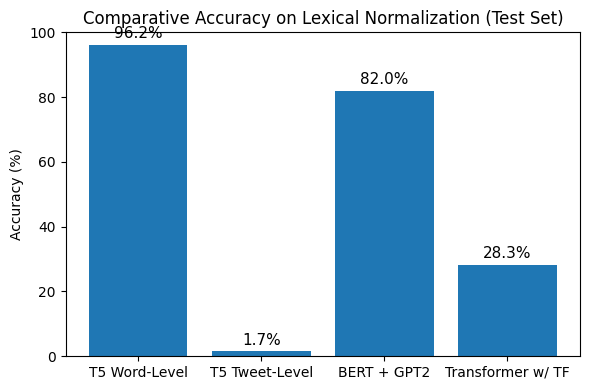

In [ ]:
model_names = ['T5 Word-Level', 'T5 Tweet-Level', 'BERT + GPT2', 'Transformer w/ TF'] #specify Trans tyoe - word or tweet level
accuracies = [0.962, 0.017, 0.82, 0.283]  # change BERT

accuracies_percent = [a * 100 if a <= 1 else a for a in accuracies]

plt.figure(figsize=(6, 4))
bars = plt.bar(model_names, accuracies_percent)
plt.ylabel('Accuracy (%)')
plt.title('Comparative Accuracy on Lexical Normalization (Test Set)')
plt.ylim(0, 100)

# Annotate each bar with the value
for bar, acc in zip(bars, accuracies_percent):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{acc:.1f}%', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()
